# Import libraries

In [1]:
import sigma
from sigma.utils import normalisation as norm 
from sigma.utils import visualisation as visual
from sigma.utils.load import SEMDataset
from sigma.utils.loadtem import TEMDataset
from sigma.src.utils import same_seeds
from sigma.src.dim_reduction import Experiment
from sigma.models.autoencoder import AutoEncoder
from sigma.src.segmentation import PixelSegmenter
from sigma.gui import gui

# Load emi/ser files
Note that the `.emi` and the corresponding `.ser` files should be place in the same folder, e.g., `test.emi` and `test.ser` should be in the same folder.

In [3]:
tem = TEMDataset('Fe_particles_in_CAIs.emi')

In [4]:
tem.set_xray_lines(['C_Ka', 'O_Ka', 'Fe_La','Mg_Ka', 'Al_Ka', 'Si_Ka', 
                    'S_Ka', 'Ca_Ka', 'Ca_Kb', 'Fe_Ka', 'Fe_Kb', 'Co_Ka', 
                    'Ni_Ka','Cu_Ka', 'Cu_Kb'])

Set xray_lines to ['C_Ka', 'O_Ka', 'Fe_La', 'Mg_Ka', 'Al_Ka', 'Si_Ka', 'S_Ka', 'Ca_Ka', 'Ca_Kb', 'Fe_Ka', 'Fe_Kb', 'Co_Ka', 'Ni_Ka', 'Cu_Ka', 'Cu_Kb']


# Dataset preprocessing

## View the dataset

Use `gui.view_emi_dataset(tem)` to check the BSE image, the sum spectrum, and the elemental maps. Here we can use the small widgets to search the energy peaks and determine the elements for further amalyses. 

After setting the `Feature list`, we obtain the elemental maps hyperspectral imaging dataset (HSI) with the dimension of 279 x 514 x 9 (for the test file).

Output()

Output()

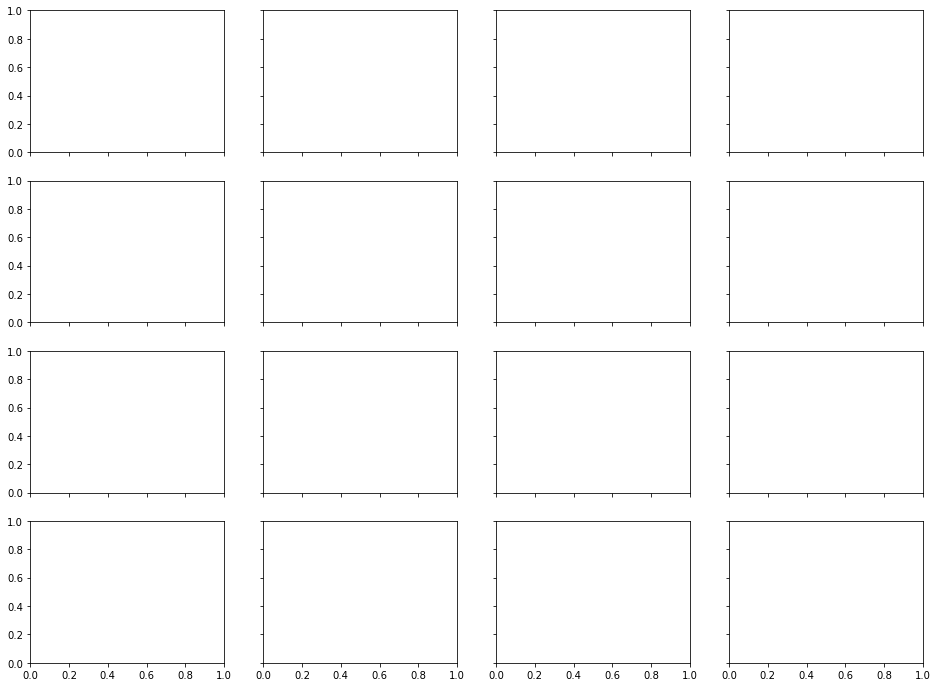

In [5]:
gui.view_emi_dataset(tem)

## Process the dataset

In [ ]:
# Rebin both edx and bse dataset
tem.rebin_signal(size=(2,2))

# normalisation to make the spectrum of each pixel summing to 1.
tem.peak_intensity_normalisation()

# Remove the first peak until the energy of 0.1 keV
tem.remove_fist_peak(end=0.1) 

# Denoise the X-ray profile using PCA.
tem.peak_denoising_PCA(n_components_to_reconstruct=10, plot_results=False)

In [ ]:
# View the dataset (bse, edx etc.) again to check differences.
gui.view_emi_dataset(tem)

The pre-processing steps yield a HSI datacube with the dimension of 139 x 257 x 9 (due to the 2x2 binning).

## Normalisation

Before dimensionality reduction, we normalise the elemental maps use `tem.normalisation()`, where we can pass a list containing (optional) sequential normalisation steps.

In [ ]:
# Normalise the dataset using the (optional) sequential three methods.
tem.normalisation([norm.neighbour_averaging, 
                   norm.zscore, 
                   norm.softmax])

Use `gui.view_pixel_distributions` to view the intensity distributions after each sequential normalisation process.

In [ ]:
gui.view_pixel_distributions(tem, 
                             norm_list=[norm.neighbour_averaging,
                                        norm.zscore,
                                        norm.softmax], 
                             peak='Fe_Ka', 
                             cmap='inferno')

## (Optional) Assign RGB to elemental peaks

In [ ]:
gui.view_rgb(tem)

## Check elemental distribution after normalisation

In [ ]:
print('After normalisation:')
gui.view_intensity_maps(edx=tem.normalised_elemental_data, element_list=tem.feature_list)

# Dimensionality reduction: Autoencoder

## Initialise experiment / model

In [ ]:
# The integer in this function can determine different initialised parameters of model (tuning sudo randomness)
# This can influence the result of dimensionality reduction and change the latent space.
same_seeds(1)

# Set up the experiment, e.g. determining the model structure, dataset for training etc.
general_results_dir='./' 
ex = Experiment(descriptor='softmax',
                general_results_dir=general_results_dir,
                model=AutoEncoder,
                model_args={'hidden_layer_sizes':(512,256,128)}, # number of hidden layers and corresponding neurons
                chosen_dataset=tem.normalised_elemental_data,
                save_model_every_epoch=True)

## Training

In [ ]:
# Train the model
ex.run_model(num_epochs=1,
             patience=50, 
             batch_size=64,
             learning_rate=1e-4, 
             weight_decay=0.0, 
             task='train_all', # Change to 'train_eval' to train on the training set (85% dataset) and test on a testing set (15%) for evaluation
             noise_added=0.0,
             KLD_lambda=0.0,
             criterion='MSE',
             lr_scheduler_args={'factor':0.5,
                                'patience':5, 
                                'threshold':1e-2, 
                                'min_lr':1e-6,
                                'verbose':True}) 

# Pixel segmentation: Gaussian mixture modelling (GMM) clustering

## (Optional) Load pre-trained Autoencoder

In [ ]:
model_path = './' # model path
ex.load_trained_model(model_path)

## Measure Baysian information criterion (BIC)

The `gui.view_bic` iteratively calculates the BIC for Gaussian mixture models using the number of Gaussian components `n_components`, e.g. if `n_components=20`, it shows the BIC values for GMM using n_components from 1 to 20.

In [ ]:
latent = ex.get_latent()
gui.view_bic(latent,
             n_components=20,
             model_args={'random_state':6, 'init_params':'kmeans'})

## Run GMM

In [ ]:
latent = ex.get_latent()
ps = PixelSegmenter(latent, 
                    tem.normalised_elemental_data, 
                    tem,
                    method_args={'n_components':12, 'random_state':6, 'init_params':'kmeans'} )
                    # can change random_state to different integer i.e. 10 or 0 to adjust the clustering result.

## Checking latent space

In [ ]:
# Plot latent sapce (2-dimensional) with corresponding Gaussian models
gui.view_latent_space(ps, color=True)

In [ ]:
# visualise the latent space
gui.check_latent_space(ps,ratio_to_be_shown=0.5, show_map=True)

In [ ]:
# check the density of latent space
gui.plot_latent_density(ps, bins=50)

## Checking each clusters

In [ ]:
ps.set_feature_list(['Al_Ka', 'C_Ka', 'Ca_Ka', 'Fe_Ka', 'K_Ka', 'O_Ka', 'Si_Ka', 'Ti_Ka', 'Zn_La'])
gui.show_cluster_distribution(ps)

## Checking cluster map

In [ ]:
# Plot phase map using the corresponding GM model
gui.view_phase_map(ps)

In [ ]:
gui.view_clusters_sum_spectra(ps, normalisation=True, spectra_range=(0,8))

# Unmixing cluster spectrums using Non-negative Matrix Fatorization (NMF)

In [ ]:
weights, components = ps.get_unmixed_edx_profile(clusters_to_be_calculated='All', 
                                                 n_components='All',
                                                 normalised=False, 
                                                 method='NMF', 
                                                 method_args={'init':'nndsvd'})

In [ ]:
gui.show_unmixed_weights_and_compoments(ps, weights, components)

# Statistics infro from clusters

In [ ]:
gui.show_cluster_stats(ps)